In [9]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_decision_forests as tfdf

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [10]:
# Download price data from Yahoo Finance for selected stocks and S&P 500
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "META", "^GSPC"]  # example stocks + S&P500 index
data = yf.download(tickers, start="2020-04-30", end="2025-04-30")['Close']
data = data.dropna()
data

[*********************100%***********************]  6 of 6 completed


Ticker,AAPL,AMZN,GOOGL,META,MSFT,^GSPC
Date,,,,,,
2020-04-30,71.299095,123.699997,67.014603,203.749710,171.535980,2912.429932
2020-05-01,70.151230,114.302002,65.552597,201.321152,167.094727,2830.709961
2020-05-04,71.143791,115.799500,65.830269,204.297134,171.181793,2842.739990
2020-05-05,72.211578,115.889999,67.130051,206.098648,173.019638,2868.439941
2020-05-06,72.956581,117.563004,66.951401,207.492096,174.723419,2848.419922
...,...,...,...,...,...,...
2025-04-23,204.600006,180.600006,155.350006,520.270020,374.390015,5375.859863
2025-04-24,208.369995,186.539993,159.279999,533.150024,387.299988,5484.770020
2025-04-25,209.279999,188.990005,161.960007,547.270020,391.850006,5525.209961


In [11]:
def compute_features(df):
    features = pd.DataFrame(index=df.index)
    
    features["Return_1M"] = df.pct_change(periods=1)
    features["Return_3M"] = df.pct_change(periods=3)
    features["Return_6M"] = df.pct_change(periods=6)
    features["Volatility_3M"] = df.pct_change().rolling(3).std()
    features["Volatility_6M"] = df.pct_change().rolling(6).std()
    
    return features

# Apply to each stock except the benchmark
features = {}
for ticker in tickers[:-1]:
    stock_df = data[ticker]
    features[ticker] = compute_features(stock_df)

# Create label (1 if outperforming S&P500 next month)
returns = data.pct_change().shift(-1)
benchmark_return = returns["^GSPC"]

for ticker in tickers[:-1]:
    f = features[ticker].copy()
    f["Future_Return"] = returns[ticker]
    f["Benchmark"] = benchmark_return
    f["Outperform"] = (f["Future_Return"] > f["Benchmark"]).astype(int)
    f["Ticker"] = ticker
    features[ticker] = f.dropna()

# Combine into a single dataset
df_all = pd.concat(features.values())
df_all.reset_index(inplace=True)
df_all.head()

,Date,Return_1M,Return_3M,Return_6M,Volatility_3M,Volatility_6M,Future_Return,Benchmark,Outperform,Ticker
0,2020-05-08,0.023802,0.045065,0.058439,0.007777,0.013514,0.015736,0.000133,1,AAPL
1,2020-05-11,0.015736,0.050670,0.092686,0.006772,0.004945,-0.011428,-0.020500,1,AAPL
2,2020-05-12,-0.011428,0.028027,0.065128,0.018457,0.011878,-0.012074,-0.017463,1,AAPL
3,2020-05-13,-0.012074,-0.007997,0.036708,0.015873,0.014694,0.006143,0.011525,0,AAPL
4,2020-05-14,0.006143,-0.017365,0.032425,0.010336,0.014553,-0.005912,0.003926,0,AAPL


In [12]:
import plotly.express as px
# Iterate through each stock and plot the selected features
features = ["Return_1M", "Return_3M", "Return_6M", "Volatility_3M", "Volatility_6M"]

for ticker in tickers[:-1]:  # Exclude the benchmark
    stock_data = df_all[df_all["Ticker"] == ticker]
    fig = px.line(
        stock_data,
        x="Date",
        y=features,
        title=f"Features for {ticker}",
        labels={"value": "Feature Value", "variable": "Feature"},
    )
    fig.update_layout(legend_title_text="Features")
    fig.show()

In [13]:
# Remove rows with any missing values
df_all = df_all.dropna()

# Define features and label
feature_columns = ["Return_1M", "Return_3M", "Return_6M", "Volatility_3M", "Volatility_6M"]
label_column = "Outperform"

# Convert to TF dataset
def df_to_tf_dataset(dataframe):
    return tfdf.keras.pd_dataframe_to_tf_dataset(dataframe, label=label_column, task=tfdf.keras.Task.CLASSIFICATION)

# Convert the 'Date' column to a numeric format before splitting
df_all['Date'] = pd.to_numeric(df_all['Date'])

# Split the dataset
train_df, test_df = train_test_split(df_all, test_size=0.2, shuffle=False)

train_ds = df_to_tf_dataset(train_df)
test_ds = df_to_tf_dataset(test_df)


In [14]:
model = tfdf.keras.RandomForestModel()
model.fit(train_ds)

# Summary
model.summary()

Use /tmp/tmppvga7k98 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.132608. Found 4996 examples.
Training model...


I0000 00:00:1746103813.623329    7913 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1746103813.623349    7913 kernel.cc:783] Collect training examples
I0000 00:00:1746103813.623355    7913 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1746103813.623408    7913 kernel.cc:401] Number of batches: 5
I0000 00:00:1746103813.623412    7913 kernel.cc:402] Number of examples: 4996
I0000 00:00:1746103813.623805    7913 kernel.cc:802] Training dataset:
Number of records: 4996
Number of columns: 10

Number of columns by type:
	NUMERICAL: 8 (80%)
	CATEGORICAL: 2 (20%)

Columns:

NUMERICAL: 8 (80%)
	0: "Benchmark" NUMERICAL mean:0.000576452 

Model trained in 0:00:00.437535
Compiling model...
Model compiled.
Model: "random_forest_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (9):
	Benchmark
	Date
	Future_Return
	Return_1M
	Return_3M
	Return_6M
	Ticker
	Volatility_3M
	Volatility_6M

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1. "Future_Return"  0.446483 ################
    2.     "Benchmark"  0.341395 ##########
    3.          "Date"  0.155455 ##
    4. "Volatility_6M"  0.130706 
    5. "Volatility_3M"  0.130206 
    6.     "Return_6M"  0.124973 
    7.     "Return_3M"  0.124818 
    8.     "Return_1M"  0.119952 
    9.        "Ticker"  0.112061 

Variable Importance: NUM_AS_ROOT:
 

I0000 00:00:1746103814.049648    7913 decision_forest.cc:808] Model loaded with 300 root(s), 78178 node(s), and 9 input feature(s).
I0000 00:00:1746103814.049697    7913 abstract_model.cc:1439] Engine "RandomForestOptPred" built
2025-05-01 19:50:14.049713: I tensorflow_decision_forests/tensorflow/ops/inference/kernel.cc:1035] Use fast generic engine


2/2 [==============================] - 0s 6ms/step
Accuracy: 0.9815852682145717
F1 Score: 0.9814665592264303
ROC AUC: 0.9989076923076923


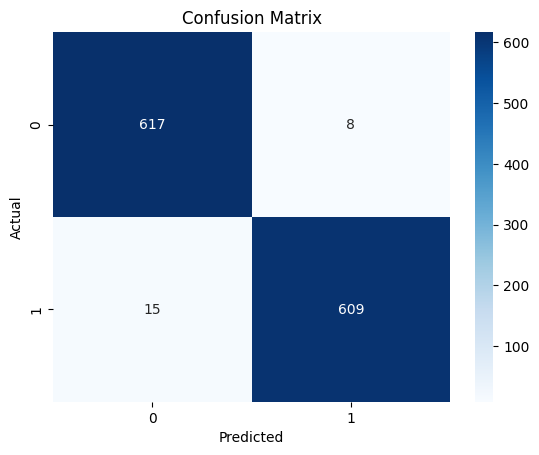

In [15]:
# Evaluate on test set
test_predictions = model.predict(test_ds)
predicted_probs = np.array([p[0] for p in test_predictions])
predicted_labels = (predicted_probs > 0.5).astype(int)

y_true = test_df[label_column].values

print("Accuracy:", accuracy_score(y_true, predicted_labels))
print("F1 Score:", f1_score(y_true, predicted_labels))
print("ROC AUC:", roc_auc_score(y_true, predicted_probs))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_true, predicted_labels), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
